## FPoliSolutions, LLC; Asset Monitoring and Predictive Maintenance

## Models

### Arnab Dey Sarkar
Here we will try to fit different models and play with the parameters. This is a classification problem. Hence, we need to use logistic regression.

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold

In [67]:
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [68]:
df=pd.read_csv("training_data.csv")

In [69]:
df_clean=df.dropna().copy()

In [70]:
df_clean_copy=df.copy()

df_clean_copy_features = df_clean_copy.drop(columns=['Y'])

Let's start our journey with seeing relation with X01 and Y.

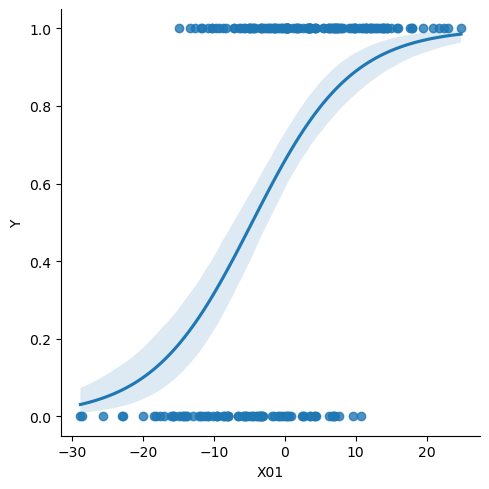

In [71]:
sns.lmplot(data = df_clean, x='X01', y='Y', logistic=True)

plt.show()

In [72]:
import statsmodels.formula.api as smf

Let's fit one simple model. I am avoiding the intercept model for now.

In [73]:
fit_basic = smf.logit(formula='Y ~ X01', data=df_clean).fit()

Optimization terminated successfully.
         Current function value: 0.514632
         Iterations 6


In [74]:
print(fit_basic.summary())

                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                  223
Model:                          Logit   Df Residuals:                      221
Method:                           MLE   Df Model:                            1
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.2257
Time:                        01:13:48   Log-Likelihood:                -114.76
converged:                       True   LL-Null:                       -148.21
Covariance Type:            nonrobust   LLR p-value:                 2.857e-16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6563      0.167      3.927      0.000       0.329       0.984
X01            0.1430      0.022      6.595      0.000       0.101       0.186


In [75]:
def my_coefplot(mod, figsize_use=(10, 4)):
    fig, ax = plt.subplots(figsize=figsize_use)
    
    ax.errorbar( y=mod.params.index,
                 x=mod.params,
                 xerr = 2 * mod.bse,
                 fmt='o', color='k', ecolor='k', elinewidth=2, ms=10)
    
    ax.axvline(x=0, linestyle='--', linewidth=3.5, color='grey')
    
    ax.set_xlabel('coefficient value')
    
    plt.show()

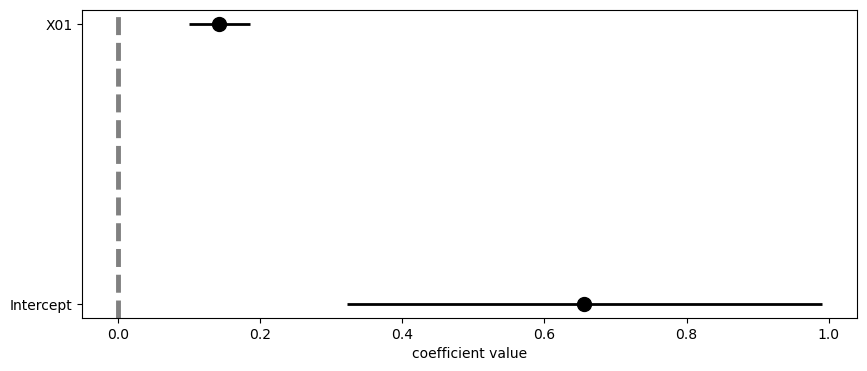

In [76]:
my_coefplot(fit_basic)

We can see that both the intercept and coefficient of X01 is statistically significant.

In [77]:
df_basic_viz = pd.DataFrame({'X01': np.linspace(min(df_clean.X01)-0.1, max(df_clean.X01)+0.1, num=501)})

df_basic_viz.nunique()

X01    501
dtype: int64

In [78]:
df_basic_viz_copy = df_basic_viz.copy()
df_basic_viz_copy['pred']= fit_basic.predict( df_basic_viz )

df_basic_viz_copy.head()

,X01,pred
0,-28.875101,0.030091
1,-28.767498,0.030543
2,-28.659896,0.031002
3,-28.552293,0.031468
4,-28.444690,0.031940


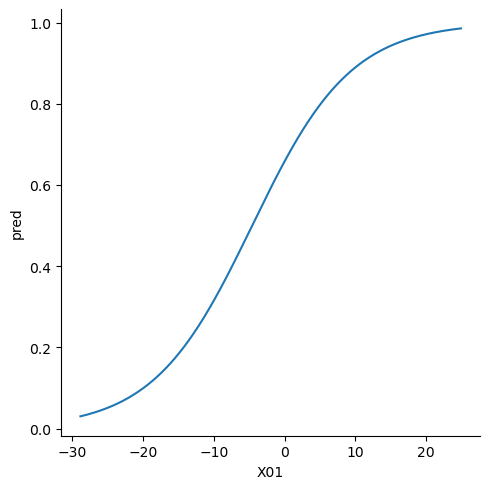

In [79]:
sns.relplot(data = df_basic_viz_copy, x='X01', y='pred', kind='line')

plt.show()

Here we have explore the relation b/w X01 and Y but we have 63 inputs. Hence even with additive model with all the features the no of different coefficient is 63 which is a lot. Hence, we need to create a pipeline to reduce the no of impactful feature variables. Alongside PCA will also work on those variables and transform them into uncorrelated variables.

In [80]:
df.shape

(223, 64)

In [81]:
input_names = df.drop(columns=['Y']).columns
lf= df.copy().\
reset_index().\
rename(columns={'index': 'rowid'}).\
melt(id_vars=['rowid', 'Y'], value_vars=input_names, ignore_index=True)

We have observed in the EDA that some variables are highly skewed which will impact the pca method. Hence, we need to eliminate the skew effect.

In [82]:
high_skew_inputs = input_names[ np.abs(df.drop(columns=['Y']).skew()) > 1 ]

In [83]:
high_skew_inputs

Index(['Z07', 'Z08', 'Z09', 'V02', 'V11', 'V27', 'V28', 'V29'], dtype='object')

In [84]:
# check if the values are negative because the log and square root transformations cannot be applied to negative values
lf.loc[ (lf.variable.isin(high_skew_inputs)) & (lf.value < 0), :].groupby(['variable']).size()

variable
V02    110
V11    119
V29    215
Z09    136
dtype: int64

In [85]:
lf_skew = lf.loc[ lf.variable.isin(high_skew_inputs), :].copy()

lf_skew = lf_skew.loc[ ~lf_skew.variable.isin(['V02', 'V11', 'V29', 'Z09']), :].copy()

In [86]:
lf_skew['shift_value'] = 1 - lf_skew.value
lf_skew['log_shift_value'] = np.log( lf_skew.shift_value )

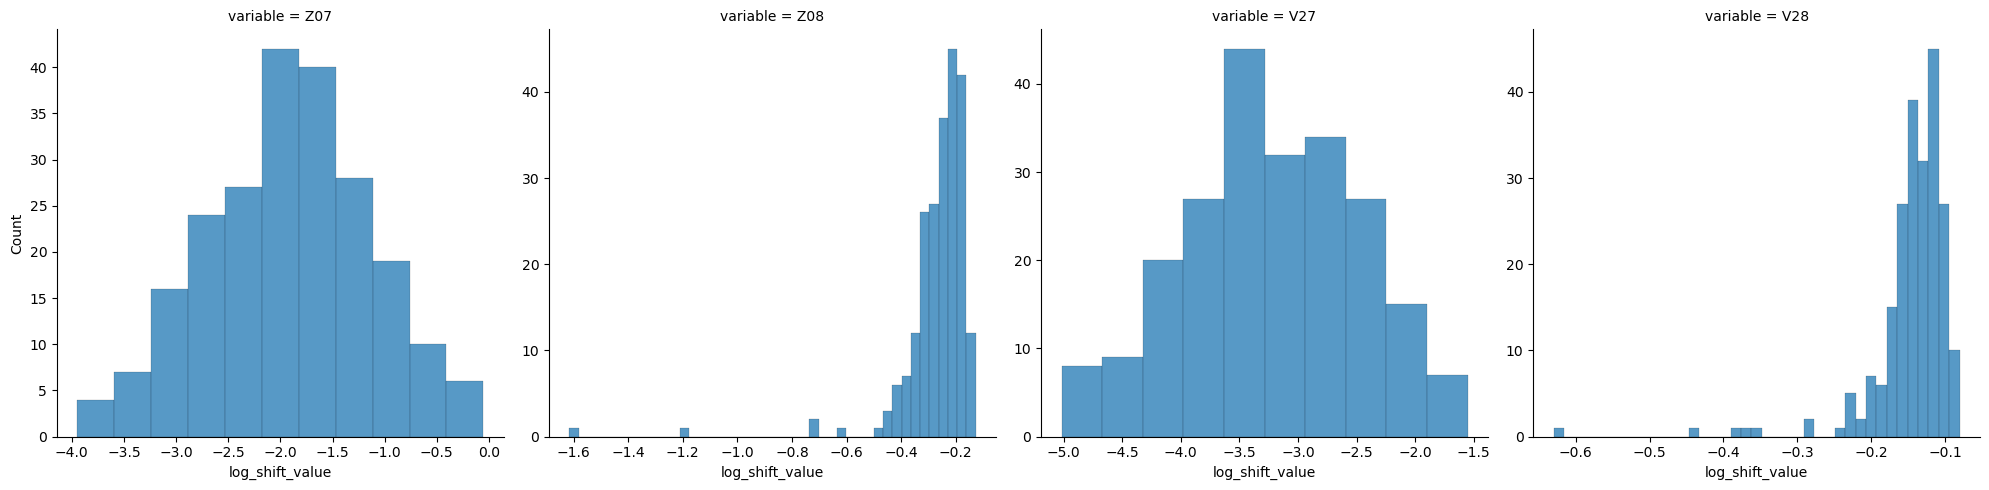

In [87]:
 sns.displot(data = lf_skew, 
            x='log_shift_value', col='variable', kind='hist', col_wrap=4,
            facet_kws={'sharex': False, 'sharey': False},
            common_bins=False)

plt.show()

In [88]:
lf_skew.head()

,rowid,Y,variable,value,shift_value,log_shift_value
6913,0,1,Z07,0.051581,0.948419,-0.052959
6914,1,1,Z07,0.773052,0.226948,-1.483032
6915,2,1,Z07,0.945183,0.054817,-2.903762
6916,3,0,Z07,0.837018,0.162982,-1.814117
6917,4,1,Z07,0.477282,0.522718,-0.648713


In [89]:
# Convert to short format using pivot
data = lf_skew.pivot(index='rowid', columns='variable', values='log_shift_value').reset_index()
data = data.drop(columns=['rowid'])

In [90]:
df_transformed = df.copy()
df_transformed = df_transformed.drop(columns=['Z07','Z08','V27','V28'])


In [91]:
df_transformed['Z07'] = data['Z07']
df_transformed['Z08'] = data['Z08']
df_transformed['V27'] = data['V27']
df_transformed['V28'] = data['V28']

In [92]:
df_transformed.dtypes

X01    float64
X02    float64
X03    float64
X04    float64
X05    float64
        ...   
Y        int64
Z07    float64
Z08    float64
V27    float64
V28    float64
Length: 64, dtype: object

In [93]:
df_transformed.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,...,V23,V24,V25,V26,V29,Y,Z07,Z08,V27,V28
0,-2.907070,1.266914,-0.332039,-0.248782,0.200432,-0.008683,0.316866,-0.323924,0.030199,-0.205569,...,1.113175,-0.240931,-0.108875,-0.114766,-121.810994,1,-0.052959,-0.249629,-1.842834,-0.110079
1,-4.608052,4.672474,0.154697,0.268719,-0.842417,0.055191,0.622848,-0.260097,-0.651079,1.096821,...,1.656029,2.428749,1.068637,1.945175,-59.362086,1,-1.483032,-0.302265,-3.006666,-0.154656
2,4.338816,5.684974,1.868370,-1.883006,0.589758,0.932240,-0.646026,0.183410,0.132287,-0.426386,...,2.661607,2.625942,4.462401,3.621299,-79.575912,1,-2.903762,-0.346509,-4.877172,-0.136740
3,-1.835062,0.427501,-2.226023,0.700375,-1.144850,1.188100,0.727831,-0.271734,0.003246,0.138308,...,-0.882442,-0.832196,-0.377106,-0.633452,-139.426151,0,-1.814117,-0.177379,-3.329320,-0.093188
4,13.990969,-3.877269,1.921605,0.162288,2.316402,-0.161137,-0.099180,0.514620,-0.551956,-0.517779,...,-0.557930,-0.185135,-0.639549,-0.245234,-29.433234,1,-0.648713,-0.312156,-1.869612,-0.189111


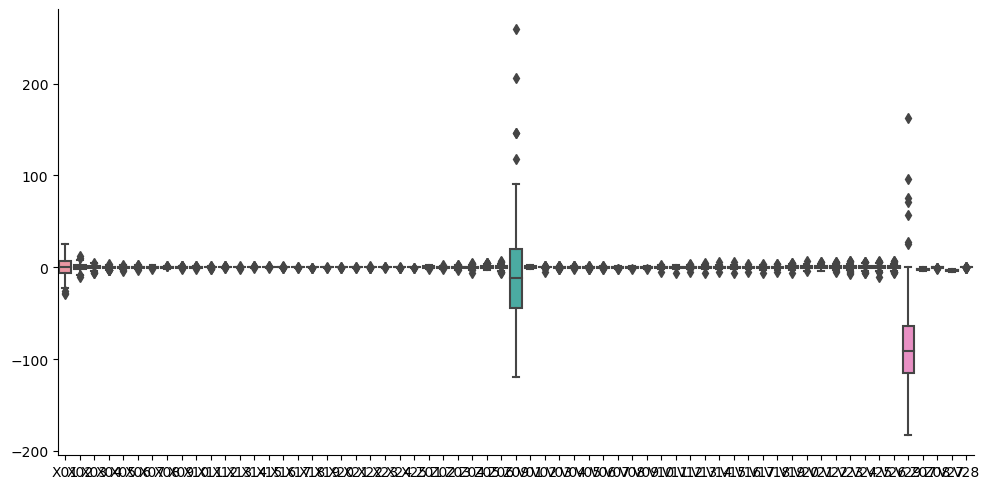

In [94]:
sns.catplot(data = df_transformed.drop(columns=['Y']), kind='box', aspect=2)

plt.show()

These are biased under scaling. We clearly need to scale the data.

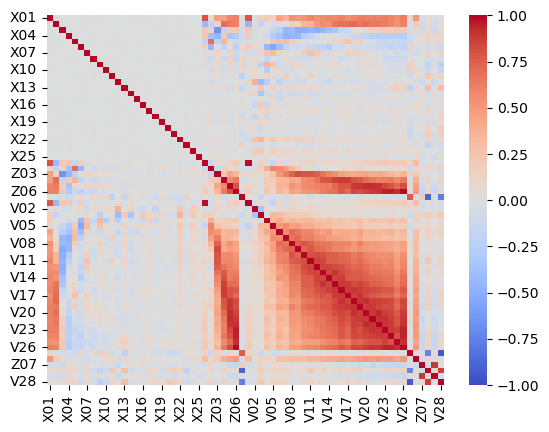

In [95]:
fig, ax = plt.subplots()

sns.heatmap(data = df_transformed.corr(numeric_only=True),
            vmin=-1, vmax=1, center=0,
            cmap='coolwarm', 
            ax=ax)

plt.show()

We observe The INPUTS are HIGHLY correlated. Let us first standardize the original data and later we will look at the transformed data. We will also do PCA for each data

Apply PCA to the original inputs and create linear additive features from the PCs.

In [96]:
# Standardize original data df

df_features = df.drop(columns=['Y'])

In [97]:
df_features.columns

Index(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'X22', 'X23', 'X24', 'X25', 'Z01', 'Z02', 'Z03', 'Z04', 'Z05',
       'Z06', 'Z07', 'Z08', 'Z09', 'V01', 'V02', 'V03', 'V04', 'V05', 'V06',
       'V07', 'V08', 'V09', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16',
       'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26',
       'V27', 'V28', 'V29'],
      dtype='object')

In [98]:
# Let's now standardize the numeric columns
X_features = StandardScaler().fit_transform(df_features )

In [99]:
X_features.shape

(223, 63)

In [100]:
X_pca = PCA().fit_transform( X_features )

In [101]:
df_pca = pd.DataFrame( X_pca, 
                             columns=['pc%02d' % d for d in range(1, X_pca.shape[1]+1)])

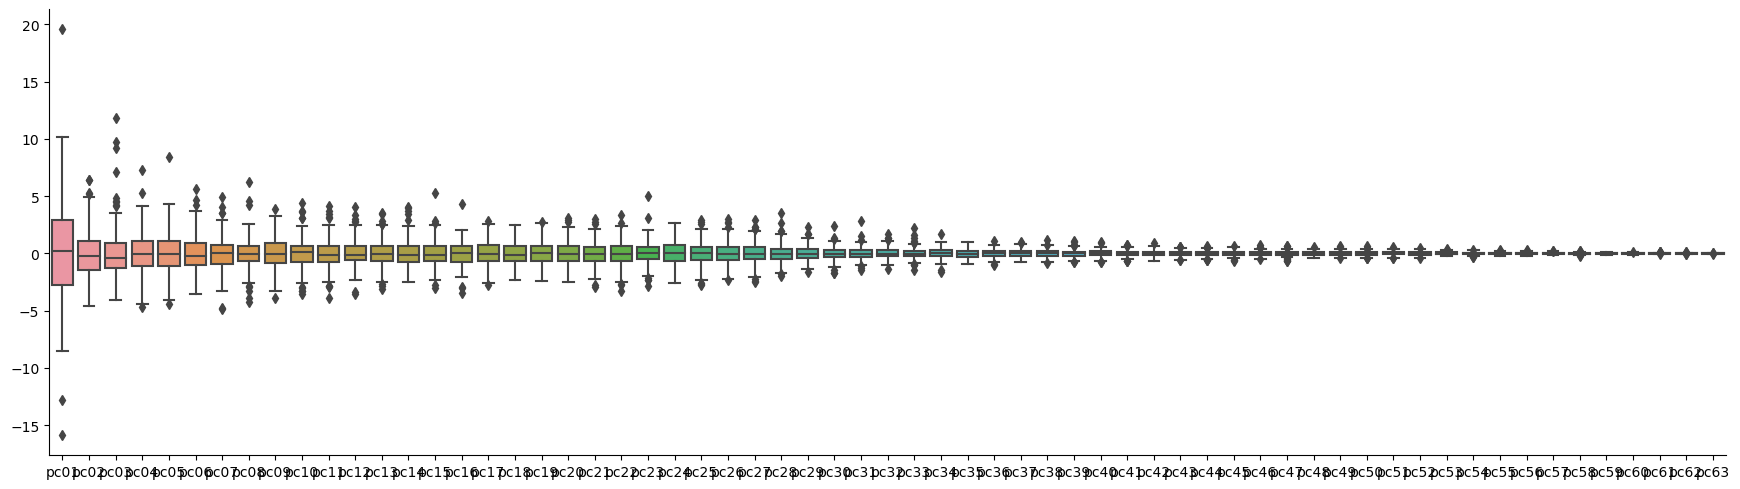

In [102]:
sns.catplot(data = df_pca, kind='box', aspect=3.5)

plt.show()

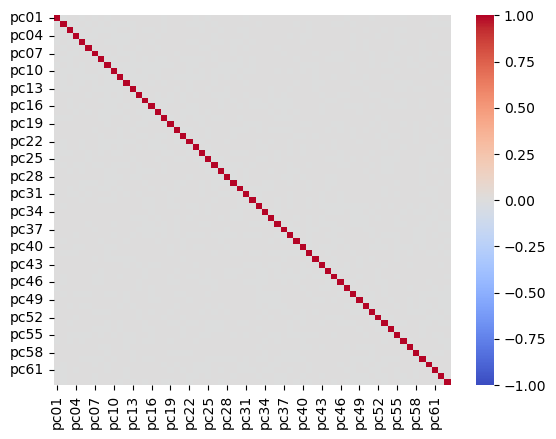

In [103]:
fig, ax = plt.subplots()

sns.heatmap(data = df_pca.corr(numeric_only=True),
            vmin=-1, vmax=1, center=0,
            cmap='coolwarm',
            ax=ax)

plt.show()

In [104]:
# Original data df

xinputs = df.drop(columns=['Y'].copy())
youtput = df.loc[:, ['Y']].copy()

Convert the DataFrames to NumPy arrays.

In [105]:
x_train = xinputs.to_numpy()
y_train = youtput.Y.to_numpy().ravel()

In [106]:
lasso_to_fit = LogisticRegression(penalty='l1', solver='saga',
                                  random_state=202, max_iter=25001,
                                  fit_intercept=True)

In [107]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

In [108]:
pc_wflow_df = Pipeline( steps=[('std_inputs', StandardScaler()), 
                                  ('pca', PCA()),
                              ('lasso', lasso_to_fit)] )

In [109]:
pc_wflow_df 

Pipeline(steps=[('std_inputs', StandardScaler()), ('pca', PCA()),
                ('lasso',
                 LogisticRegression(max_iter=25001, penalty='l1',
                                    random_state=202, solver='saga'))])

In [110]:
pc_grid = {'pca__n_components': [3, 5, 7, 9, 11, 13, 15, 17],
                 'lasso__C': np.exp( np.linspace(-10, 10, num=17) ) }

In [111]:
pc_df_search = GridSearchCV(pc_wflow_df, param_grid=pc_grid, cv=kf)

In [112]:
pc_df_search_results = pc_df_search.fit( x_train, y_train )

In [113]:
pc_df_search_results.best_params_

{'lasso__C': 42.52108200006278, 'pca__n_components': 13}

In [114]:
pc_df_search_results.best_estimator_.named_steps['lasso'].coef_

array([[-0.47454915,  0.2307099 , -0.22926733, -0.50843733,  0.06441166,
        -0.00346299,  0.03271162,  0.19884548, -0.18645119, -0.0925052 ,
         0.28380242,  0.04475419,  0.05504333]])

In [115]:
pc_df_search_results.best_score_

0.775959595959596

In [116]:
make_pairs1= PolynomialFeatures(degree=1)

In [117]:
pc_interact_df_wflow1 = Pipeline( steps=[('std_inputs', StandardScaler() ), 
                                           ('pca', PCA() ), 
                                           ('make_pairs1', make_pairs1), 
                                           ('lasso', lasso_to_fit )] )

In [118]:
pc_interact_df_search1 = GridSearchCV( pc_interact_df_wflow1, param_grid=pc_grid, cv=kf )

In [119]:
x_train.shape

(223, 63)

In [120]:
pc_interact_df_search_grid1 = pc_interact_df_search1.fit( x_train, y_train )
pc_interact_df_search_grid1.best_score_

0.7758585858585858

In [121]:
pc_interact_df_search_grid1.best_params_

{'lasso__C': 1.0, 'pca__n_components': 13}

Thus for both statmodels and scikit learn for data df only taking 13 pca components in enough although they are giving two different C values. Let us interact PC and check how many componenets we need.

In [122]:
make_pairs = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [123]:
pc_interact_df_wflow = Pipeline( steps=[('std_inputs', StandardScaler() ), 
                                           ('pca', PCA() ), 
                                           ('make_pairs', make_pairs), 
                                           ('lasso', lasso_to_fit )] )

In [124]:
pc_interact_df_wflow

Pipeline(steps=[('std_inputs', StandardScaler()), ('pca', PCA()),
                ('make_pairs',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('lasso',
                 LogisticRegression(max_iter=25001, penalty='l1',
                                    random_state=202, solver='saga'))])

In [125]:
pc_interact_df_search = GridSearchCV( pc_interact_df_wflow, param_grid=pc_grid, cv=kf )

In [126]:
pc_interact_df_search_grid = pc_interact_df_search.fit( x_train, y_train )

In [127]:
pc_interact_df_search_grid.best_estimator_.named_steps['lasso'].coef_

array([[-0.52927103,  0.17834677, -0.2778546 , -0.42953977,  0.        ,
         0.        , -0.03543668,  0.        ,  0.        ,  0.        ,
         0.11061709, -0.01190105, -0.03408656, -0.12045736, -0.01973917,
         0.        ,  0.07251106,  0.0232851 ,  0.01408075, -0.11884243,
         0.06719067,  0.        , -0.02507968,  0.04042531, -0.03933093,
         0.04910943,  0.        ,  0.20338251,  0.        , -0.03570296,
        -0.14182865, -0.13252312,  0.02818562,  0.0348126 ,  0.        ,
         0.        , -0.10612056,  0.        , -0.17836496,  0.        ,
         0.        ,  0.04256143,  0.11498021, -0.00994531, -0.18565547,
        -0.01460533, -0.05310027, -0.01549336,  0.        ,  0.17117249,
         0.        ,  0.02607172,  0.        ,  0.        ,  0.        ,
        -0.15301015,  0.03642813, -0.08801133,  0.07464166, -0.02632265,
        -0.0808537 , -0.27461458,  0.        , -0.25779601, -0.13589364,
         0.        ]])

In [128]:
pc_interact_df_search_grid.best_score_

0.7891919191919193

In [129]:
pc_interact_df_search_grid.best_params_

{'lasso__C': 0.2865047968601901, 'pca__n_components': 11}

Thus for data df only taking 11 pca components in enough for interactions. Let us interact PC and check how many componenets we need.

In [130]:
# Convert the standardized features to a DataFrame
df_standardized = pd.DataFrame(X_features, columns=df_features.columns)


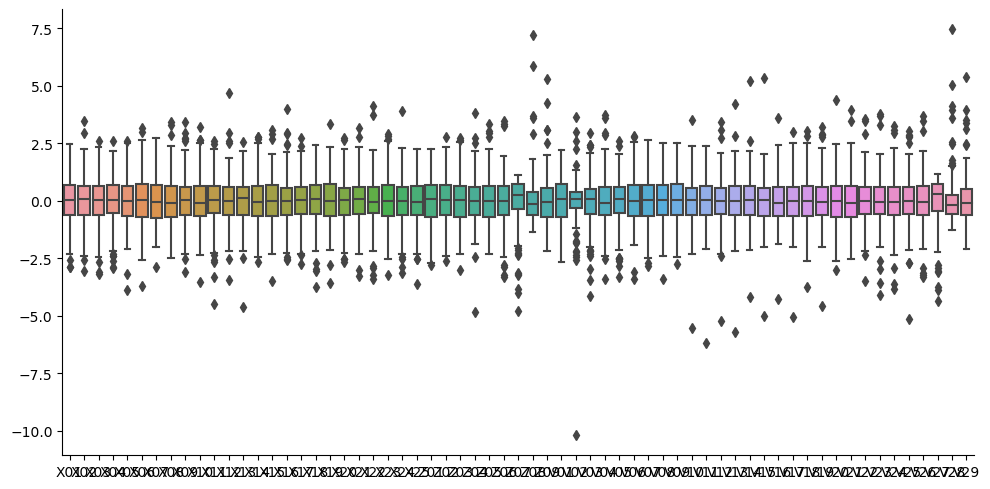

In [131]:
# check standardization worked
sns.catplot(data = pd.DataFrame(X_features, columns=df_features.columns),
            kind='box', aspect=2)

plt.show()

In [132]:
df_features_transformed = df_transformed.drop(columns=['Y'])

In [133]:
df_features_transformed.columns

Index(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'X22', 'X23', 'X24', 'X25', 'Z01', 'Z02', 'Z03', 'Z04', 'Z05',
       'Z06', 'Z09', 'V01', 'V02', 'V03', 'V04', 'V05', 'V06', 'V07', 'V08',
       'V09', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V29', 'Z07',
       'Z08', 'V27', 'V28'],
      dtype='object')

In [134]:
# Let's now standardize the numeric columns
X_features_transformed = StandardScaler().fit_transform(df_features_transformed )
X_features_transformed.shape

(223, 63)

In [135]:
# Convert the standardized features to a DataFrame
df_standardized_transformed = pd.DataFrame(X_features_transformed, columns=df_features_transformed.columns)



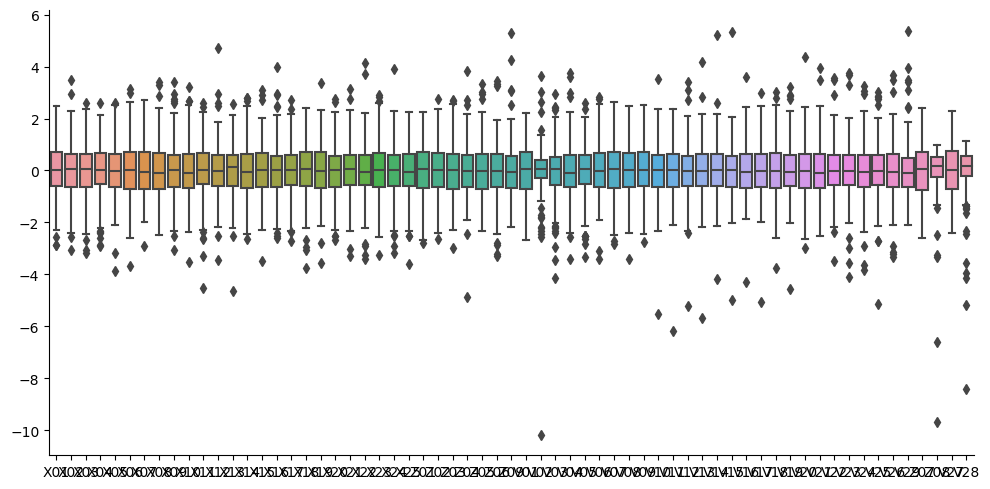

In [136]:
# check standardization worked
sns.catplot(data = pd.DataFrame(X_features_transformed, columns=df_features_transformed.columns), kind='box', aspect=2)

plt.show()

## Part iv) Models – fitting and interpretation

In [137]:
df_standardized['Y'] = df.Y

In [138]:
df_standardized_transformed['Y'] = df.Y

**Model 1**

In [139]:
mod_01 = smf.logit(formula='Y ~ 1', data=df_standardized).fit()

Optimization terminated successfully.
         Current function value: 0.664632
         Iterations 4


In [140]:
mod_01.params

Intercept    0.484602
dtype: float64

**Model 2**

In [141]:
formula_linear = 'Y ~ ' + ' + '.join(df_standardized.drop(columns= 'Y').columns)
mod_02 = smf.ols(formula=formula_linear, data=df_standardized).fit()                    

In [142]:
 mod_02.params

Intercept    0.618834
X01         -0.645561
X02         -0.005390
X03         -0.033813
X04          0.193554
               ...   
V25         -0.006285
V26          0.261143
V27         -0.143461
V28         -0.013623
V29         -0.087232
Length: 64, dtype: float64

In [189]:
mod_02.pvalues[mod_02.pvalues<0.05]

Intercept    1.961723e-52
X10          3.168272e-02
V07          2.052326e-02
V15          1.888079e-02
dtype: float64

In [143]:
df_transformed.columns

Index(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'X22', 'X23', 'X24', 'X25', 'Z01', 'Z02', 'Z03', 'Z04', 'Z05',
       'Z06', 'Z09', 'V01', 'V02', 'V03', 'V04', 'V05', 'V06', 'V07', 'V08',
       'V09', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V29', 'Y',
       'Z07', 'Z08', 'V27', 'V28'],
      dtype='object')

**Model 3**

In [144]:
formula_linear = 'Y ~ ' + ' + '.join(df_standardized_transformed.drop(columns= 'Y').columns)
mod_03 = smf.ols(formula=formula_linear, data=df_standardized_transformed).fit() 

In [145]:
mod_03.params

Intercept    0.618834
X01         -0.593080
X02          0.123625
X03         -0.000392
X04          0.124743
               ...   
V29          0.039919
Z07          0.353333
Z08         -0.007782
V27         -0.356414
V28         -0.287535
Length: 64, dtype: float64

We have already applied pca in the pipeline and found out that 13 feature as are good for additive model.

**Model 4**

In [146]:
df_pca['Y'] = df.Y

In [147]:
df_pca_add = df_pca.iloc[:, :13].copy()

In [148]:
df_pca_add['Y'] = df_transformed.Y

In [149]:
formula_linear = 'Y ~ ' + ' + '.join(df_pca_add.drop(columns= 'Y').columns)
mod_04 = smf.ols(formula= formula_linear, data=df_pca_add).fit()

In [150]:
mod_04.params

Intercept    0.618834
pc01        -0.056246
pc02         0.028118
pc03        -0.014650
pc04        -0.065614
pc05         0.013851
pc06         0.005205
pc07        -0.008205
pc08         0.014654
pc09        -0.031263
pc10         0.004493
pc11         0.028842
pc12         0.001153
pc13        -0.000503
dtype: float64

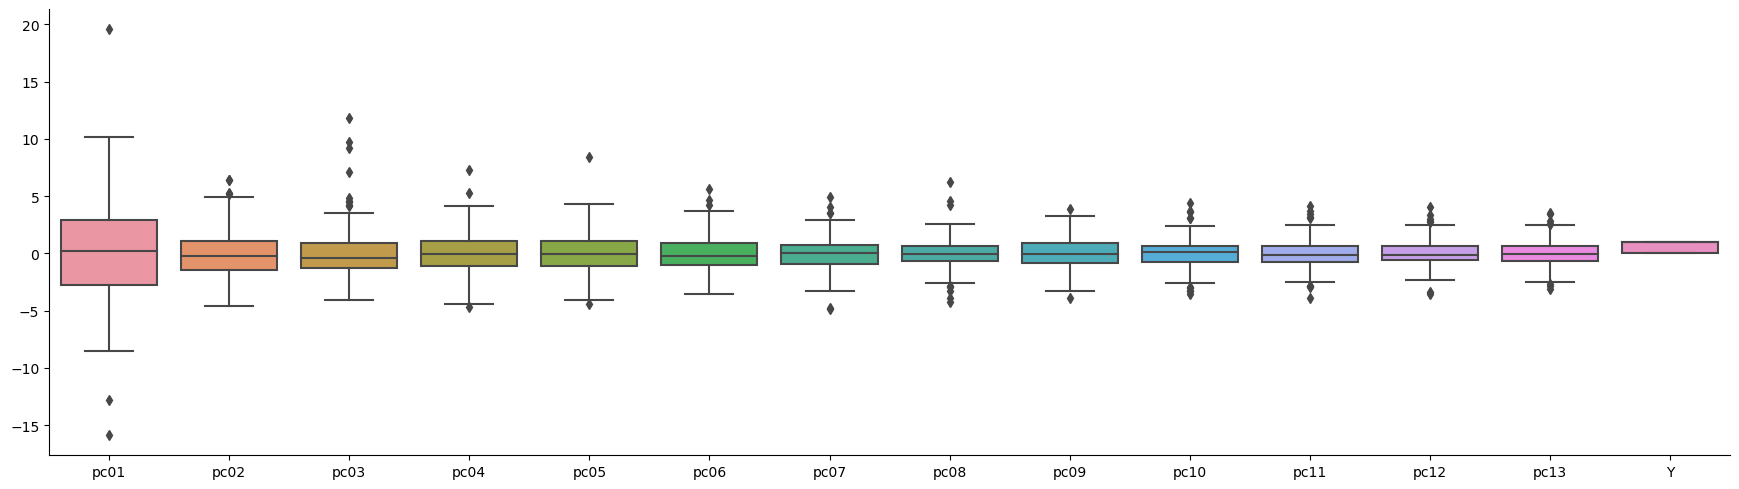

In [151]:
sns.catplot(data = df_pca_add, kind='box', aspect=3.5)

plt.show()

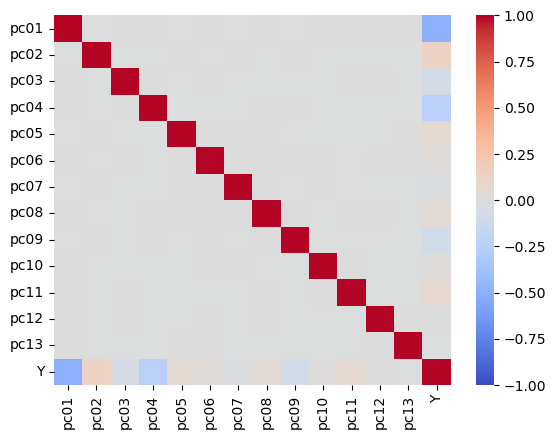

In [152]:
fig, ax = plt.subplots()

sns.heatmap(data = df_pca_add.corr(numeric_only=True),
            vmin=-1, vmax=1, center=0,
            cmap='coolwarm',
            ax=ax)

plt.show()

**Model 5**

In [156]:
# Apply PCA to the transformed inputs and create linear additive features from the PCs.

X_pca_transformed = PCA().fit_transform(X_features_transformed)


In [157]:
df_pca_transformed = pd.DataFrame( X_pca_transformed, 
                             columns=['pc%02d' % d for d in range(1, X_pca_transformed .shape[1]+1)])

In [158]:
df_pca_transformed_add = df_pca_transformed.iloc[:, :13].copy()
df_pca_transformed_add['Y'] = df_standardized_transformed.Y

In [159]:
# create linear additive features from the PCs for the transformed inputs
formula_linear = 'Y ~ ' + ' + '.join(df_pca_transformed_add.drop(columns= 'Y').columns)
mod_05 = smf.ols(formula= formula_linear, data=df_pca_transformed_add).fit()
mod_05.params

Intercept    0.618834
pc01        -0.056253
pc02         0.027810
pc03        -0.015859
pc04        -0.064549
pc05         0.016296
pc06         0.011370
pc07         0.009033
pc08         0.019110
pc09        -0.019236
pc10         0.006173
pc11         0.031443
pc12         0.000630
pc13         0.004637
dtype: float64

**Model 6**

In [160]:
#Apply PCA to the original inputs and create all pairwise interactions between the PCs.
df_pca_int = df_pca.iloc[:, :11].copy()
df_pca_int['Y'] = df_transformed.Y
formula_int = 'Y ~ ' + ' ( '  + ' + '.join(df_pca_int.drop(columns= 'Y').columns) + ' ) ** 2'
mod_06 = smf.ols(formula=formula_int, data=df_pca_int).fit() 

In [161]:
mod_06.params

Intercept    0.618834
pc01        -0.087747
pc02         0.053043
pc03        -0.041355
pc04        -0.075786
               ...   
pc08:pc10   -0.055417
pc08:pc11   -0.002829
pc09:pc10   -0.100069
pc09:pc11   -0.087196
pc10:pc11   -0.023330
Length: 67, dtype: float64

**Model 7**

In [162]:
# Apply PCA to the transformed inputs and create all pairwise interactions between the PCs.
df_pca_transformed_int = df_pca_transformed.iloc[:, :11].copy()
df_pca_transformed_int['Y'] = df_transformed.Y
formula_int = 'Y ~ ' + ' ( '  + ' + '.join(df_pca_transformed_int.drop(columns= 'Y').columns) + ' ) ** 2'
mod_07 = smf.ols(formula=formula_int, data=df_pca_transformed_int).fit() 
mod_07.params

Intercept    0.618834
pc01        -0.085394
pc02         0.042771
pc03        -0.053285
pc04        -0.072074
               ...   
pc08:pc10    0.018514
pc08:pc11    0.032776
pc09:pc10   -0.109349
pc09:pc11   -0.057338
pc10:pc11   -0.017328
Length: 67, dtype: float64

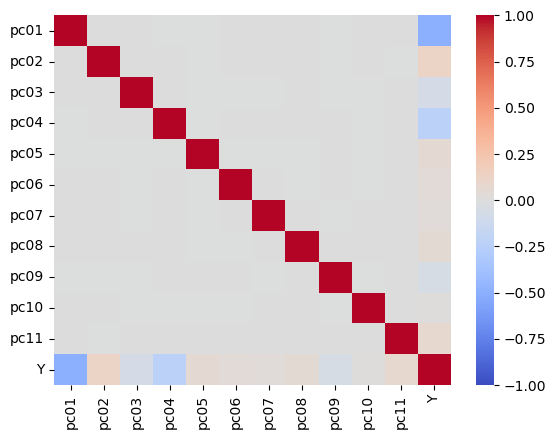

In [163]:
fig, ax = plt.subplots()

sns.heatmap(data = df_pca_transformed_int.corr(numeric_only=True),
            vmin=-1, vmax=1, center=0,
            cmap='coolwarm',
            ax=ax)

plt.show()

## Prediction

Let us look at each model and study the following:
(1) How many coefficients were estimated?
(2) How many coefficients (and thus features) are STATISTICALLY SIGNIFICANT
using commonly accepted thresholds?
(3) WHICH coefficients (and thus features) are STATISTICALLY SIGNIFICANT and what are the coefficients POSITIVE or NEGATIVE for those features?
(4) Which two STATISTICALLY SIGNIFICANT coefficients (and thus features) have the highest MAGNITUDE coefficient values?

CLASSIFICATION - For each model show:
• The CONFUSION MATRIX on the training set assuming a 0.5 threshold.
• The Accuracy, Sensitivity, Specificity, and FPR on the training set assuming a 0.5 threshold.
• The ROC curve on the training set.
• The Area Under the ROC curve (ROC AUC) value.
(5) Which model has the best performance on the training set?
(6) Is the best model different when considering Accuracy vs ROC AUC?
(7) Is the best model better than the INTERCEPT-ONLY model?
(8) How many coefficients are associated with the BEST model?

In [164]:
def fit_and_assess_logistic(a_mod, train_data, threshold, mod_name):
    
    
    train_copy = train_data.copy()
    
    train_copy['pred_probability'] = a_mod.predict( train_data )
    
    train_copy['pred_class'] = np.where( train_copy.pred_probability > threshold, 1, 0 )
    
    TN, FP, FN, TP = confusion_matrix( train_copy.Y.to_numpy(), train_copy.pred_class.to_numpy() ).ravel()
    
    Accuracy = (TN + TP) / (TN + FP + FN + TP)
    
    Sensitivity = (TP) / (TP + FN)
    
    Specificity = (TN) / (TN + FP)
    
    FPR = 1 - Specificity
    
    ROC_AUC = roc_auc_score( train_copy.Y.to_numpy(), train_copy.pred_probability.to_numpy() )
    
    res_dict = {'model_name': mod_name,
                'num_coefs': len( a_mod.params ),
                'threshold': threshold,
                'Accuracy': Accuracy,
                'Sensitivity': Sensitivity,
                'Specificity': Specificity,
                'FPR': FPR,
                'ROC_AUC': ROC_AUC}
    return pd.DataFrame( res_dict, index=[0] )
    

In [165]:
# Model 1
mod_01.params

Intercept    0.484602
dtype: float64

In [166]:
mod_01.pvalues < 0.05

Intercept    True
dtype: bool

In [167]:
result=[]
result.append(fit_and_assess_logistic(mod_01, df_standardized, 0.5,'mod_01'))

We estimate one coefficient i.e. the intercept which is statistically significant and has a positive value.

In [168]:
# model 2 
mod_02.params

Intercept    0.618834
X01         -0.645561
X02         -0.005390
X03         -0.033813
X04          0.193554
               ...   
V25         -0.006285
V26          0.261143
V27         -0.143461
V28         -0.013623
V29         -0.087232
Length: 64, dtype: float64

In [169]:
mod_02.pvalues < 0.05

Intercept     True
X01          False
X02          False
X03          False
X04          False
             ...  
V25          False
V26          False
V27          False
V28          False
V29          False
Length: 64, dtype: bool

In [170]:
result.append(fit_and_assess_logistic(mod_02, df_standardized, 0.5,'mod_02'))

We estimate 64 coefficients and only the intercept  is statistically significant and has a positive value.

In [171]:
# model 3 
mod_03.params

Intercept    0.618834
X01         -0.593080
X02          0.123625
X03         -0.000392
X04          0.124743
               ...   
V29          0.039919
Z07          0.353333
Z08         -0.007782
V27         -0.356414
V28         -0.287535
Length: 64, dtype: float64

In [172]:
mod_03.pvalues < 0.05

Intercept     True
X01          False
X02          False
X03          False
X04          False
             ...  
V29          False
Z07          False
Z08          False
V27          False
V28          False
Length: 64, dtype: bool

We estimate 5 coefficients and none of them are statistically significant

In [173]:
result.append(fit_and_assess_logistic(mod_03, df_standardized_transformed, 0.5,'mod_03'))

In [174]:
# model 4 
mod_04.params

Intercept    0.618834
pc01        -0.056246
pc02         0.028118
pc03        -0.014650
pc04        -0.065614
pc05         0.013851
pc06         0.005205
pc07        -0.008205
pc08         0.014654
pc09        -0.031263
pc10         0.004493
pc11         0.028842
pc12         0.001153
pc13        -0.000503
dtype: float64

In [175]:
mod_04.pvalues < 0.05

Intercept     True
pc01          True
pc02          True
pc03         False
pc04          True
pc05         False
pc06         False
pc07         False
pc08         False
pc09         False
pc10         False
pc11         False
pc12         False
pc13         False
dtype: bool

We estimate 27 coefficients and  intercept(positive) ,pc01(negative) ,pc02(positive) ,pc04(negative) ,pc14(negative) ,pc24(negative) is statistically significant with signs written in the bracket

In [176]:
result.append(fit_and_assess_logistic(mod_04, df_pca_add, 0.5,'mod_04'))

In [177]:
# model 5 
mod_05.params

Intercept    0.618834
pc01        -0.056253
pc02         0.027810
pc03        -0.015859
pc04        -0.064549
pc05         0.016296
pc06         0.011370
pc07         0.009033
pc08         0.019110
pc09        -0.019236
pc10         0.006173
pc11         0.031443
pc12         0.000630
pc13         0.004637
dtype: float64

In [178]:
mod_05.pvalues < 0.05

Intercept     True
pc01          True
pc02          True
pc03         False
pc04          True
pc05         False
pc06         False
pc07         False
pc08         False
pc09         False
pc10         False
pc11         False
pc12         False
pc13         False
dtype: bool

In [179]:
result.append(fit_and_assess_logistic(mod_05, df_pca_transformed_add, 0.5,'mod_05'))

In [180]:
# model 6
mod_06.params
mod_06.pvalues < 0.05

Intercept     True
pc01          True
pc02          True
pc03          True
pc04          True
             ...  
pc08:pc10     True
pc08:pc11    False
pc09:pc10     True
pc09:pc11     True
pc10:pc11    False
Length: 67, dtype: bool

In [181]:
result.append(fit_and_assess_logistic(mod_07, df_pca_int, 0.5,'mod_06'))

In [182]:
# model 7
mod_07.params

Intercept    0.618834
pc01        -0.085394
pc02         0.042771
pc03        -0.053285
pc04        -0.072074
               ...   
pc08:pc10    0.018514
pc08:pc11    0.032776
pc09:pc10   -0.109349
pc09:pc11   -0.057338
pc10:pc11   -0.017328
Length: 67, dtype: float64

In [183]:
mod_07.pvalues < 0.05

Intercept     True
pc01          True
pc02          True
pc03          True
pc04          True
             ...  
pc08:pc10    False
pc08:pc11    False
pc09:pc10     True
pc09:pc11     True
pc10:pc11    False
Length: 67, dtype: bool

In [184]:
result.append(fit_and_assess_logistic(mod_07, df_pca_transformed_int, 0.5,'mod_07'))

We estimate 7 coefficients and only the intercept is statistically significant and has a positive value

In [185]:
results_df = pd.concat( result, ignore_index=True)

In [186]:
results_df

,model_name,num_coefs,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
0,mod_01,1,0.5,0.618834,1.000000,0.000000,1.000000,0.500000
1,mod_02,64,0.5,0.887892,0.934783,0.811765,0.188235,0.930179
2,mod_03,64,0.5,0.869955,0.913043,0.800000,0.200000,0.928815
3,mod_04,14,0.5,0.798206,0.869565,0.682353,0.317647,0.868286
4,mod_05,14,0.5,0.807175,0.876812,0.694118,0.305882,0.865303
5,mod_06,67,0.5,0.789238,0.847826,0.694118,0.305882,0.853623
6,mod_07,67,0.5,0.896861,0.898551,0.894118,0.105882,0.954390


Which model has the best performance on the training set?
• Is the best model different when considering Accuracy vs ROC AUC?
• Is the best model better than the INTERCEPT-ONLY model?
• How many coefficients are associated with the BEST model?

According to the ROC_AUC mod_07(Apply PCA to the transformed inputs and create all pairwise interactions between the PCs) is the best.

According to the ACCURACY mod_07 is the best.
67 coefficients are assciated to the best model.